In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, balanced_accuracy_score, average_precision_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import statsmodels.formula.api as smf
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import shap
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log as log_link  # log link for Gamma
from feature_engine.encoding import MeanEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [602]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 60% !important; }</style>"))

In [603]:
df = pd.read_csv('financial_loan.csv')
df

,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38571,803452,NJ,INDIVIDUAL,< 1 year,Joseph M Sanzari Company,C,MORTGAGE,11-07-2021,16-05-2021,16-05-2021,...,C1,60 months,Verified,100000.0,0.1986,551.64,0.1299,24250,33,31946
38572,970377,NY,INDIVIDUAL,8 years,Swat Fame,C,RENT,11-10-2021,16-04-2021,16-05-2021,...,C1,60 months,Verified,50000.0,0.0458,579.72,0.1349,25200,18,31870
38573,875376,CA,INDIVIDUAL,5 years,Anaheim Regional Medical Center,D,RENT,11-09-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,65000.0,0.1734,627.93,0.1749,25000,20,35721
38574,972997,NY,INDIVIDUAL,5 years,Brooklyn Radiology,D,RENT,11-10-2021,16-05-2021,16-05-2021,...,D5,60 months,Verified,368000.0,0.0009,612.72,0.1825,24000,9,33677


In [604]:
df['loan_status'].value_counts()

loan_status
Fully Paid     32145
Charged Off     5333
Current         1098
Name: count, dtype: int64

## Loans with ``Current`` status

Since in loans with **current** status, the borrower is still actively repaying the loan and has not yet **fully paid it off** or **defaulted**, we remove these observations from our analysis. 

In [605]:
df = df[df['loan_status']!='Current']
print(df.shape)

(37478, 24)


### Missing Values

In this dataset, there is no missing value. So, there is no need to missing values handling.

In [606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37478 entries, 0 to 38557
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     37478 non-null  int64  
 1   address_state          37478 non-null  object 
 2   application_type       37478 non-null  object 
 3   emp_length             37478 non-null  object 
 4   emp_title              36072 non-null  object 
 5   grade                  37478 non-null  object 
 6   home_ownership         37478 non-null  object 
 7   issue_date             37478 non-null  object 
 8   last_credit_pull_date  37478 non-null  object 
 9   last_payment_date      37478 non-null  object 
 10  loan_status            37478 non-null  object 
 11  next_payment_date      37478 non-null  object 
 12  member_id              37478 non-null  int64  
 13  purpose                37478 non-null  object 
 14  sub_grade              37478 non-null  object 
 15  term   

In [607]:
df.describe()

,id,member_id,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
count,3.747800e+04,3.747800e+04,3.747800e+04,37478.000000,37478.000000,37478.000000,37478.000000,37478.000000,37478.000000
mean,6.742849e+05,8.394640e+05,6.944405e+04,0.132865,324.751939,0.119595,11123.607850,22.094535,11976.920300
std,2.098643e+05,2.655468e+05,6.471923e+04,0.066598,208.848185,0.036826,7352.559241,11.415892,8818.642966
min,5.473400e+04,7.069900e+04,4.000000e+03,0.000000,15.690000,0.054200,500.000000,2.000000,34.000000
25%,5.091712e+05,6.565278e+05,4.100000e+04,0.081600,167.470000,0.089400,5500.000000,13.000000,5578.000000
50%,6.534020e+05,8.352550e+05,6.000000e+04,0.133900,280.175000,0.118300,10000.000000,20.000000,9804.500000
75%,8.269040e+05,1.034974e+06,8.300000e+04,0.185500,429.180000,0.144200,15000.000000,29.000000,16260.750000
max,1.077501e+06,1.314167e+06,6.000000e+06,0.299900,1305.190000,0.244000,35000.000000,90.000000,58564.000000


<Axes: xlabel='loan_status'>

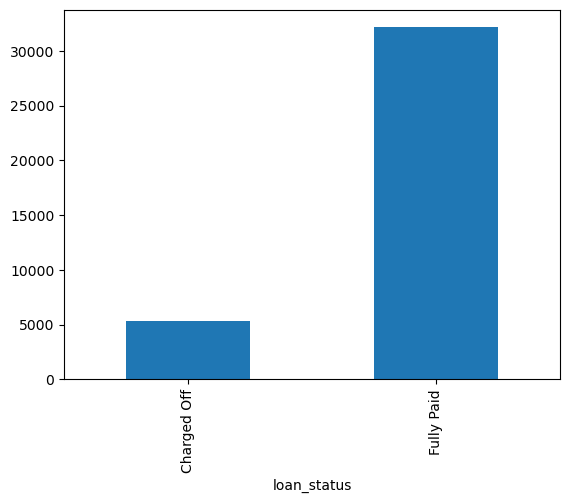

In [608]:
df['loan_status'].value_counts().sort_index().plot.bar()


In [609]:
df['term'] = df['term'].str.strip().replace({'36 months': 36, '60 months': 60})
df['term'] = df['term'].astype(int)


## Profit/Loss of Loans

In this section, we determine the profit of ``Fully Paid`` and the loss of ``Charged Off`` loans.

In [610]:
df['fee_rate'] = np.select(
    [df['grade'].isin(['A', 'B']), df['grade'].isin(['C', 'D']), df['grade'].isin(['E', 'F', 'G'])],
    [0.02, 0.05, 0.06],
    default=0.03
)


In [611]:
df['profit'] = df.apply(
    lambda row: max(row['total_payment'], row['term'] * row['installment']) - row['loan_amount']*(1-row['fee_rate'])  
    if row['loan_status'] == 'Fully Paid' 
    else row['total_payment'] - max(row['loan_amount'], row['term'] * row['installment']) , axis=1
)
# Step 1: Filter only Fully paind loans with profit <= 100
mask = (df['loan_status'] == 'Fully Paid') & (df['profit'] <= 100)

# Step 2: Filter only defaulted loans with profit >= 0
mask2 = (df['loan_status'] == 'Charged Off') & (df['profit'] >= 0)

# Step 2: Drop them
df = df[~(mask+mask2)]

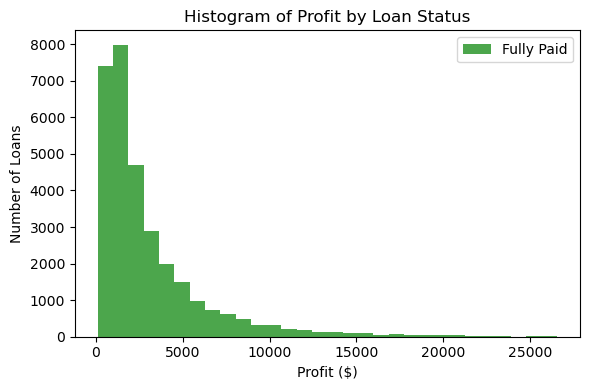

In [612]:
# Filter for each loan group
fully_paid = df[df['loan_status'] == 'Fully Paid']

# Plot histograms
plt.figure(figsize=(6, 4))

plt.hist(fully_paid['profit'], bins=30, alpha=0.7, label='Fully Paid', color='green')


plt.title('Histogram of Profit by Loan Status')
plt.xlabel('Profit ($)')
plt.ylabel('Number of Loans')
plt.legend()
plt.tight_layout()
plt.show()

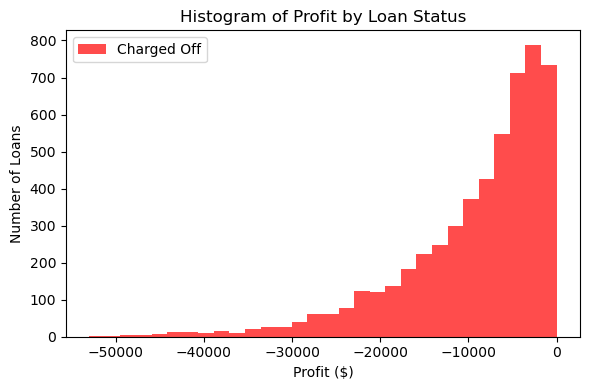

In [615]:
# Filter for each loan group
charged_off = df[df['loan_status'] == 'Charged Off']

# Plot histograms
plt.figure(figsize=(6, 4))

plt.hist(charged_off['profit'], bins=30, alpha=0.7, label='Charged Off', color='red')

plt.title('Histogram of Profit by Loan Status')
plt.xlabel('Profit ($)')
plt.ylabel('Number of Loans')
plt.legend()
plt.tight_layout()
plt.show()

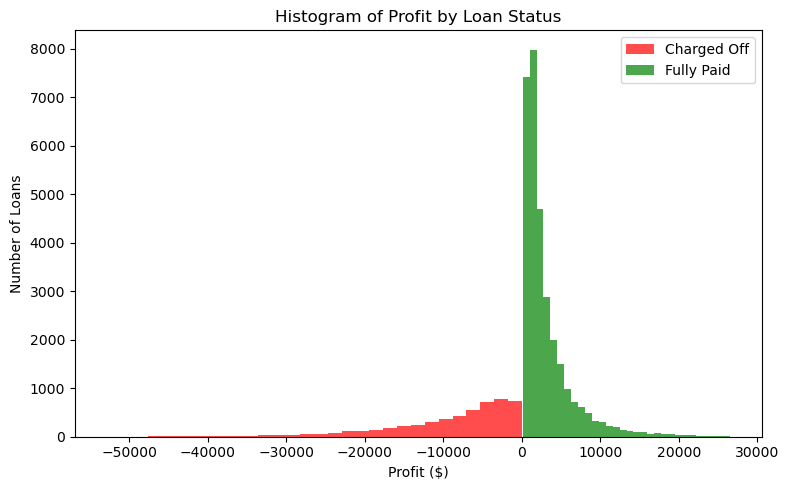

In [616]:
plt.figure(figsize=(8, 5))

plt.hist(charged_off['profit'], bins=30, alpha=0.7, label='Charged Off', color='red')
plt.hist(fully_paid['profit'], bins=30, alpha=0.7, label='Fully Paid', color='green')

plt.title('Histogram of Profit by Loan Status')
plt.xlabel('Profit ($)')
plt.ylabel('Number of Loans')
plt.legend()

plt.tight_layout()
plt.show()

In [617]:
df['loan_status'].value_counts()

loan_status
Fully Paid     31157
Charged Off     5315
Name: count, dtype: int64

### Train and Test Split

In [618]:
df['loan_status'] = df['loan_status'].replace({'Charged Off': 1,'Fully Paid': 0})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])

# 1. ``Loan_Status`` Prediction

In [619]:
irrelevant_features = ['id', 'member_id', 'emp_title', 'fee_rate']
post_loan_status = ['issue_date', 'last_credit_pull_date', 'last_payment_date', 'next_payment_date', 'total_payment', 'profit']
pd_features_remove = irrelevant_features + post_loan_status

In [620]:
train_df['loan_status'].value_counts()

loan_status
0    24925
1     4252
Name: count, dtype: int64

## Feature Selection Using LightGBM and Oversampling with F1-Score Metri

In [22]:
# Prepare data
X = train_df.drop(columns=pd_features_remove+['loan_status'])
y = train_df['loan_status']

# Convert object columns to category dtype for LightGBM
categorical_feature = list(X.select_dtypes(include=["object", "category"]).columns)
for col in categorical_feature:
    X[col] = X[col].astype('category')

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store feature importances weighted by F1 score
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f'LightGBM fold {fold+1}/10 is running ....')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Oversample minority class 
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Train model
    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train_res, y_train_res, categorical_feature=categorical_feature)

    # F1 score
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    # Weight feature importances by F1 score
    perm_importance = permutation_importance(model, X_val, y_val, scoring='f1', random_state=42)
    feature_importances[f'fold_{fold+1}'] = perm_importance.importances_mean * f1

    

# Compute average importance
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='mean_importance', ascending=False)

LightGBM fold 1/10 is running ....
LightGBM fold 2/10 is running ....
LightGBM fold 3/10 is running ....
LightGBM fold 4/10 is running ....
LightGBM fold 5/10 is running ....
LightGBM fold 6/10 is running ....
LightGBM fold 7/10 is running ....
LightGBM fold 8/10 is running ....
LightGBM fold 9/10 is running ....
LightGBM fold 10/10 is running ....


In [23]:
feature_importances = feature_importances[feature_importances['mean_importance']>0]
feature_importance_df = (
    feature_importances[['mean_importance']]
    .sort_values(by='mean_importance', ascending=False)
    .assign(cum_importance=lambda df: df['mean_importance'].cumsum() / df['mean_importance'].sum())
    .reset_index()
    .rename(columns={'index': 'Feature', 'mean_importance': 'mean_importance'})
)

feature_importance_df

,Feature,mean_importance,cum_importance
0,int_rate,0.011639,0.268602
1,term,0.008054,0.454459
2,loan_amount,0.006565,0.605948
3,annual_income,0.004644,0.713120
4,installment,0.004201,0.810059
5,sub_grade,0.003047,0.880367
6,purpose,0.002953,0.948514
7,address_state,0.001326,0.979105
8,total_acc,0.000706,0.995399
9,dti,0.000199,1.000000


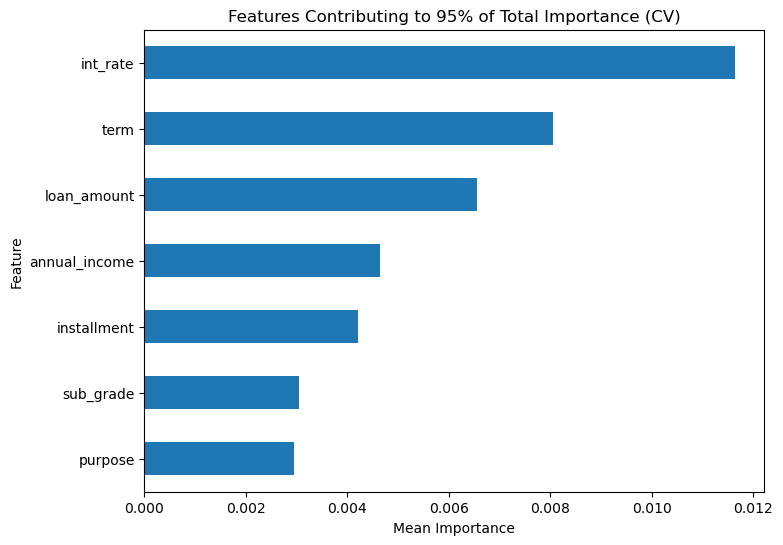

In [24]:
threshold = 0.95

# Filter features until cumulative importance reaches the threshold
threshold_df = feature_importance_df[feature_importance_df['cum_importance'] <= threshold]


# Plot
threshold_df.plot(kind='barh', x='Feature', y='mean_importance', figsize=(8, 6), legend=False)
plt.gca().invert_yaxis()
plt.title(f"Features Contributing to {threshold*100:.0f}% of Total Importance (CV)")
plt.xlabel("Mean Importance")
plt.show()

### The list of features that are the most important and are kept for further analysis

In [25]:
threshold_df

,Feature,mean_importance,cum_importance
0,int_rate,0.011639,0.268602
1,term,0.008054,0.454459
2,loan_amount,0.006565,0.605948
3,annual_income,0.004644,0.713120
4,installment,0.004201,0.810059
5,sub_grade,0.003047,0.880367
6,purpose,0.002953,0.948514


In [26]:
pd_selected_features = threshold_df['Feature'].tolist()

In [202]:
pd_selected_features = ['int_rate',
 'term',
 'loan_amount',
 'annual_income',
 'installment',
 'sub_grade',
 'purpose']

### 1.1 Preparing the data for ``Loan_Status`` Prediction

In [203]:
train_df = train_df[pd_selected_features+['loan_status']]
train_df

,int_rate,term,loan_amount,annual_income,installment,sub_grade,purpose,loan_status
14709,0.0788,36,4000,39000.0,125.13,A5,Debt consolidation,0
24091,0.2099,60,10000,100000.0,270.48,F3,Debt consolidation,0
10041,0.1774,36,14000,95000.0,504.30,E5,Debt consolidation,0
26889,0.1483,36,4750,25000.0,164.27,D3,home improvement,0
29803,0.0617,36,2000,19200.0,61.00,A3,major purchase,0
...,...,...,...,...,...,...,...,...
7114,0.0925,36,6000,45996.0,191.50,B2,Debt consolidation,1
12187,0.1287,36,10000,45000.0,336.34,C1,Debt consolidation,0
32193,0.0788,36,12000,72984.0,375.38,A5,other,0
15489,0.1268,36,12000,87500.0,402.49,C1,Debt consolidation,0


### Oversampling

In [204]:
def apply_smotenc_oversampling(df, target_column, feature_columns, categorical_columns):

    X_train = df[feature_columns].copy()
    y_train = df[target_column].copy()

    # Convert categorical columns to 'category' dtype
    for col in categorical_columns:
        X_train[col] = X_train[col].astype('category')

    # Get column indices of categorical columns
    categorical_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

    # Apply SMOTENC
    smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
    X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

    return X_resampled, y_resampled


In [205]:
X_resampled, y_resampled = apply_smotenc_oversampling(
    df=train_df,
    target_column='loan_status',
    feature_columns=pd_selected_features,
    categorical_columns=['sub_grade', 'purpose']
)


### Encoding

In [206]:
def encode_features(X_resampled, ordinal_features, nominal_features, full_feature_list):

    # Select numerical columns
    numerical_features = X_resampled[full_feature_list].select_dtypes(include='number').columns.tolist()

    # Ordinal encoding
    ordinal_encoder = OrdinalEncoder()
    X_resampled[ordinal_features] = ordinal_encoder.fit_transform(X_resampled[ordinal_features])

    # One-hot encoding for nominal features
    X_nominal_encoded = pd.get_dummies(X_resampled[nominal_features], drop_first=True)

    # Combine all together
    X_encoded = pd.concat([X_resampled[numerical_features + ordinal_features], X_nominal_encoded], axis=1)

    return X_encoded

In [207]:
ordinal_features = ['sub_grade']
nominal_features = ['purpose']

X_encoded = encode_features(X_resampled, ordinal_features, nominal_features, pd_selected_features)


In [208]:
X_encoded


,int_rate,term,loan_amount,annual_income,installment,sub_grade,purpose_car,purpose_credit card,purpose_educational,purpose_home improvement,purpose_house,purpose_major purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small business,purpose_vacation,purpose_wedding
0,0.078800,36,4000,39000.000000,125.130000,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.209900,60,10000,100000.000000,270.480000,27.0,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0.177400,36,14000,95000.000000,504.300000,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False
3,0.148300,36,4750,25000.000000,164.270000,17.0,False,False,False,True,False,False,False,False,False,False,False,False,False
4,0.061700,36,2000,19200.000000,61.000000,2.0,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49845,0.170582,60,20982,55238.150846,522.144010,21.0,False,False,False,False,False,False,False,False,False,False,False,False,False
49846,0.147836,60,12548,59244.579987,297.259800,11.0,False,False,False,False,False,False,False,False,False,False,False,False,False
49847,0.097868,44,15000,95391.964947,425.591536,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False
49848,0.110876,36,1061,35000.000000,34.780899,4.0,False,False,False,False,False,False,False,False,True,False,False,False,False


## 1.2 Hyper Parameter Tuning 


### Tuning Decision Tree Parameters Using Bayesian Optimization

In [34]:
# Define Optuna objective
def objective(trial):
    clf = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 3, 8),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 30),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        random_state=42
    )
    return cross_val_score(clf, X_encoded, y_resampled, cv=5, scoring='f1').mean()

# Run optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print results
print("Best parameters:", study.best_params)
print("Best F1 score: ", study.best_value)

Best parameters: {'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 11}
Best F1 score:  0.7113939160072186


-----------------------------------------------------

Best parameters of the Decision Tree model are:

Best parameters: {'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 11}

and corresponding F1-Score is:

Best F1 score:  0.7113939160072186

### Random Forest

In [35]:
def tune_random_forest_gridcv(X, y):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
    }

    model = RandomForestClassifier(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

# Run the tuning
best_params_rf, best_score_rf = tune_random_forest_gridcv(X_encoded, y_resampled)

# Print results
print("Best Hyper-parameters for Random Forest:")
for key, value in best_params_rf.items():
    print(f"  {key}: {value}")

print(f"Best F1 Score: {best_score_rf:.4f}")


Best Hyper-parameters for Random Forest:
  max_depth: 15
  min_samples_split: 5
  n_estimators: 100
Best F1 Score: 0.7965


### LightGBM

In [40]:
def tune_lightgbm_gridcv(X, y):
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 15, 20]
    }

    model = LGBMClassifier(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

# Run the tuning
best_params_lgbm, best_score_lgbm = tune_lightgbm_gridcv(X_encoded, y_resampled)

print("Best Hyper-parameters for LightGBM:")
for key, value in best_params_lgbm.items():
    print(f"  {key}: {value}")

print(f"Best F1 Score: {best_score_lgbm:.4f}")


Best Hyper-parameters for LightGBM:
  max_depth: 15
  n_estimators: 400
Best F1 Score: 0.8203


### XGBoost

In [39]:
def tune_xgboost_gridcv(X, y):
    param_grid = {
        'n_estimators': [200, 300, 400, 500],
        'max_depth': [ 5, 10, 15, 20]
    }

    model = XGBClassifier(
        use_label_encoder=False,
        #eval_metric='logloss',
        random_state=412,
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid_search.fit(X, y)

    return grid_search.best_params_, grid_search.best_score_

best_params_xgb, best_score_xgb = tune_xgboost_gridcv(X_encoded, y_resampled)

print("Best Hyper-parameters for XGBoost:")
for key, value in best_params_xgb.items():
    print(f"  {key}: {value}")

print(f"Best F1 Score: {best_score_xgb:.4f}")


Best Hyper-parameters for XGBoost:
  max_depth: 15
  n_estimators: 200
Best F1 Score: 0.8272


## 1.3 Interpretable Results

In this section, I explain how to interpret the model results. For the ``decision tree`` model, we can extract a clear set of rules that lead to a prediction. These rules are easy to use and make the model highly interpretable. On the other hand, other approaches like ``Random Forest`` are made up of many decision trees, and the final prediction is based on the combined results of all the trees. Since it is not possible to extract a simple set of rules from ``Random Forest``, we use the ``treeinterpreter`` library to measure how much each feature contributed to an individual’s predicted probability of default.


### 1.3.1 Decision Tree

In [41]:
# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=25, min_samples_leaf=11, random_state=42)
dt.fit(X_encoded, y_resampled)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, min_samples_split=25,
                       random_state=42)

### Sample of Rules for Prediction

Here, I present the set of rules used for the prediction of the proability of default for the first 5 customers.

In [42]:
individuals = [0, 1, 2, 3, 4]

for i in individuals:
    print(f"\n Individual {i+1}")
    obs = X_encoded.iloc[[i]]  # Keep it as DataFrame
    pred = dt.predict(obs)[0]

    node_indicator = dt.decision_path(obs)
    features = dt.tree_.feature
    thresholds = dt.tree_.threshold

    rule_path = []
    for node_id in node_indicator.indices:
        if features[node_id] != -2:
            fname = X_encoded.columns[features[node_id]]
            val = obs.iloc[0, features[node_id]]
            thresh = thresholds[node_id]
            direction = "<=" if val <= thresh else ">"
            rule_path.append(f"{fname} {direction} {thresh:.2f} (value: {val:.2f})")

    
    print("Prediction:", "Default" if pred == 1 else "Paid")
    print("Decision Rule Path:")
    for step in rule_path:
        print(" -", step)



 Individual 1
Prediction: Paid
Decision Rule Path:
 - term <= 36.50 (value: 36.00)
 - int_rate <= 0.08 (value: 0.08)
 - sub_grade <= 4.50 (value: 4.00)
 - annual_income <= 64851.42 (value: 39000.00)
 - loan_amount > 3345.50 (value: 4000.00)
 - annual_income <= 64451.00 (value: 39000.00)
 - installment <= 148.26 (value: 125.13)
 - int_rate > 0.08 (value: 0.08)

 Individual 2
Prediction: Paid
Decision Rule Path:
 - term > 36.50 (value: 60.00)
 - term > 59.50 (value: 60.00)
 - int_rate > 0.11 (value: 0.21)
 - sub_grade > 8.50 (value: 27.00)
 - loan_amount <= 15001.00 (value: 10000.00)
 - annual_income > 72988.40 (value: 100000.00)
 - purpose_major purchase <= 0.50 (value: 0.00)
 - annual_income > 86325.55 (value: 100000.00)

 Individual 3
Prediction: Paid
Decision Rule Path:
 - term <= 36.50 (value: 36.00)
 - int_rate > 0.08 (value: 0.18)
 - purpose_credit card <= 0.50 (value: 0.00)
 - sub_grade > 16.50 (value: 24.00)
 - int_rate > 0.15 (value: 0.18)
 - int_rate > 0.15 (value: 0.18)
 - a

### Visualization

In the following, we present the ``Decision Tree`` structure that has been used for decision-making. Since the depth of the decision tree is 8 and it would be difficult to visualize it, here, I just present a tree with depth 3.

Visualization


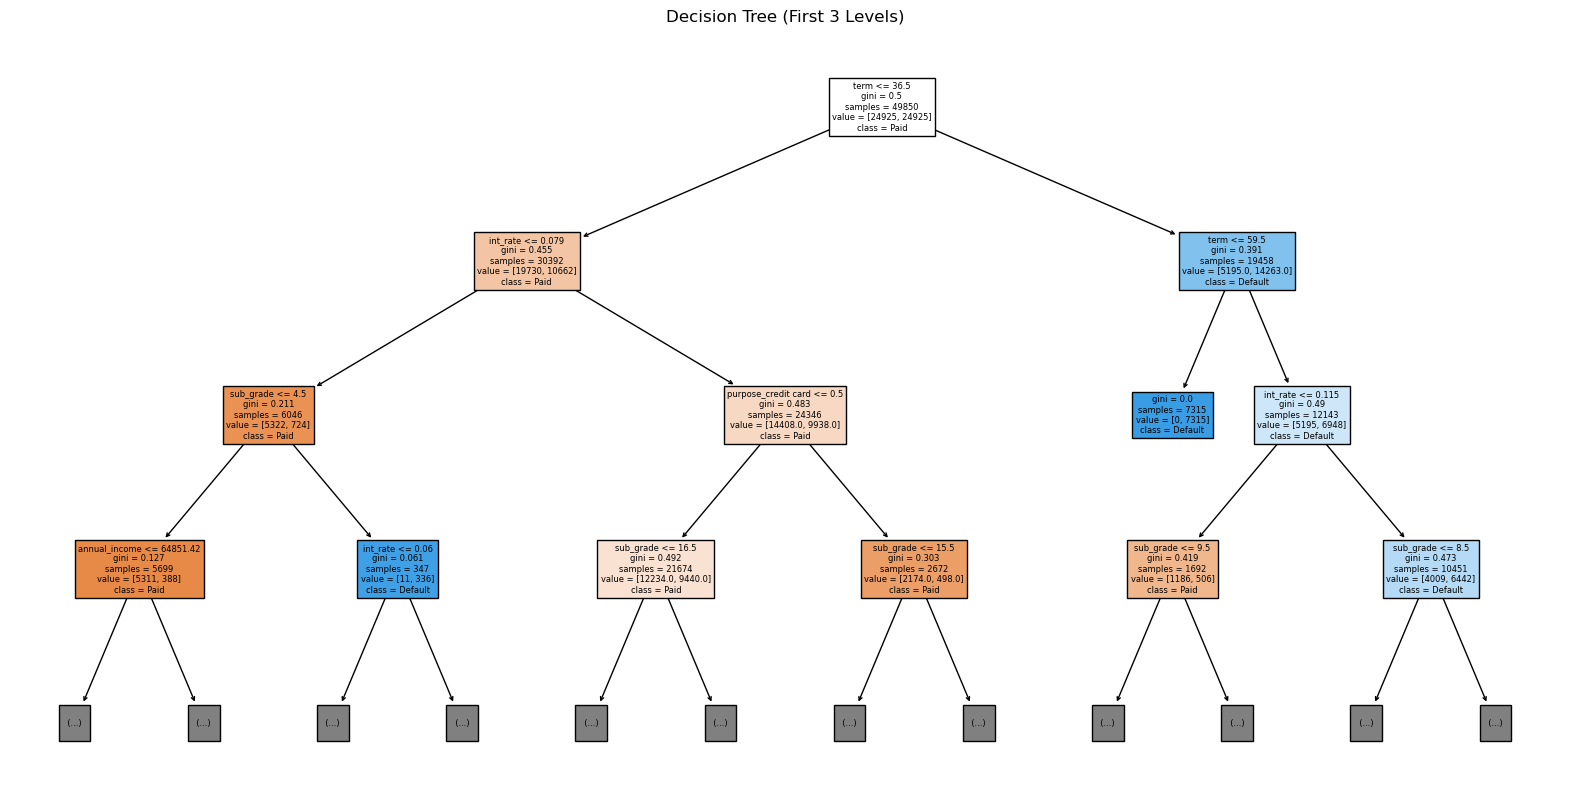

In [43]:
# Visualize first 3 levels
print("Visualization")
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X_encoded.columns,  
    class_names=['Paid', 'Default'],
    filled=True,
    max_depth=3
)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

### 1.3.2 Random Forest

In [44]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)
rf.fit(X_encoded, y_resampled)

RandomForestClassifier(max_depth=15, min_samples_split=5, random_state=42)

Now, for each individual, we can predict the probability of default and determine the contribution of each feature in this prediction. We will have a baseline probability and given the value/level of each feature, this baseline probability is adjusted. 

In [45]:
# Predict and explain with treeinterpreter
instance = X_encoded.iloc[[0]]  
prediction, bias, contributions = ti.predict(rf, instance)

print(f"Prediction probability: {prediction[0][1]:.4f}")  # class 1 = "default"
print(f"Baseline (bias):        {bias[0][1]:.4f}")
print("\n Feature contributions with actual values:")

for feature, contrib, value in zip(X_encoded.columns, contributions[0], instance.iloc[0]):
    print(f"{feature:25s} | value: {str(value):>5} | contrib to default: {contrib[1]:+.4f}")


Prediction probability: 0.1587
Baseline (bias):        0.4998

 Feature contributions with actual values:
int_rate                  | value: 0.0788 | contrib to default: -0.2164
term                      | value:    36 | contrib to default: -0.0769
loan_amount               | value:  4000 | contrib to default: -0.0153
annual_income             | value: 39000.0 | contrib to default: +0.0386
installment               | value: 125.13 | contrib to default: -0.0076
sub_grade                 | value:   4.0 | contrib to default: -0.0994
purpose_car               | value: False | contrib to default: +0.0034
purpose_credit card       | value: False | contrib to default: +0.0174
purpose_educational       | value: False | contrib to default: +0.0004
purpose_home improvement  | value: False | contrib to default: +0.0051
purpose_house             | value: False | contrib to default: +0.0004
purpose_major purchase    | value: False | contrib to default: +0.0077
purpose_medical           | value: Fal

### 1.3.3 Analyses Using SHAP on Random Forest Outputs

Here, I use ``SHAP`` library to explain the importance of features and how features affect the predicted probability of default.

In [46]:
ordinal_features = ['sub_grade']
nominal_features = ['purpose']
X = train_df[pd_selected_features]
y = train_df['loan_status']

X = encode_features(X, ordinal_features, nominal_features, pd_selected_features)
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})

In [47]:
import shap
shap.initjs()

# 1. Sample the data to speed up SHAP
X_sample, _, y_sample, _ = train_test_split(
    X, y, 
    train_size=1000, 
    stratify=y, 
    random_state=42
)


explainer = shap.TreeExplainer(rf)

shap_values = explainer(X_sample)[:,:,1]

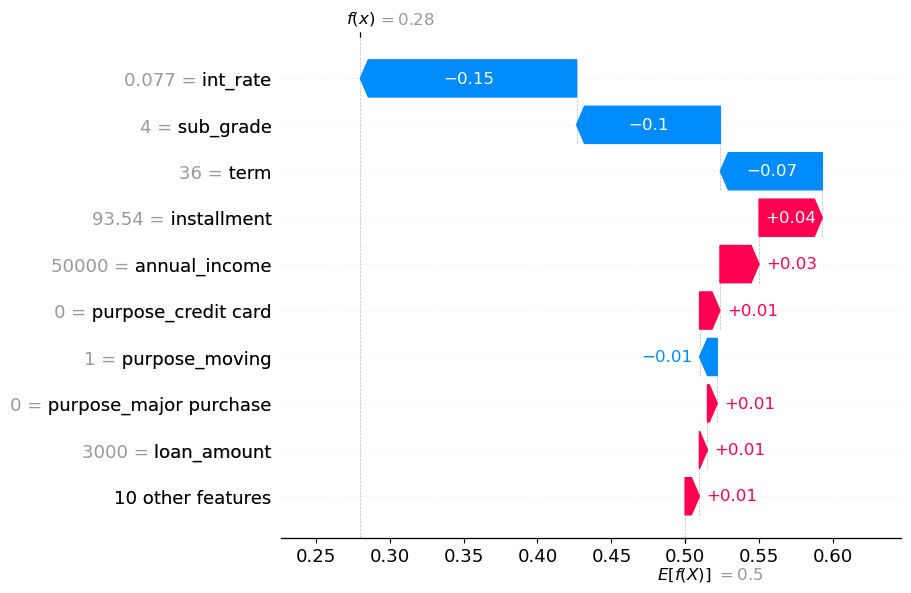

In [48]:
shap.plots.waterfall(shap_values[1])

### Force Plot

In [49]:
shap.plots.force(shap_values[0])

### Stacked Force Plot

In [41]:
shap.plots.force(shap_values[0:50])

### Absolute Mean Shap

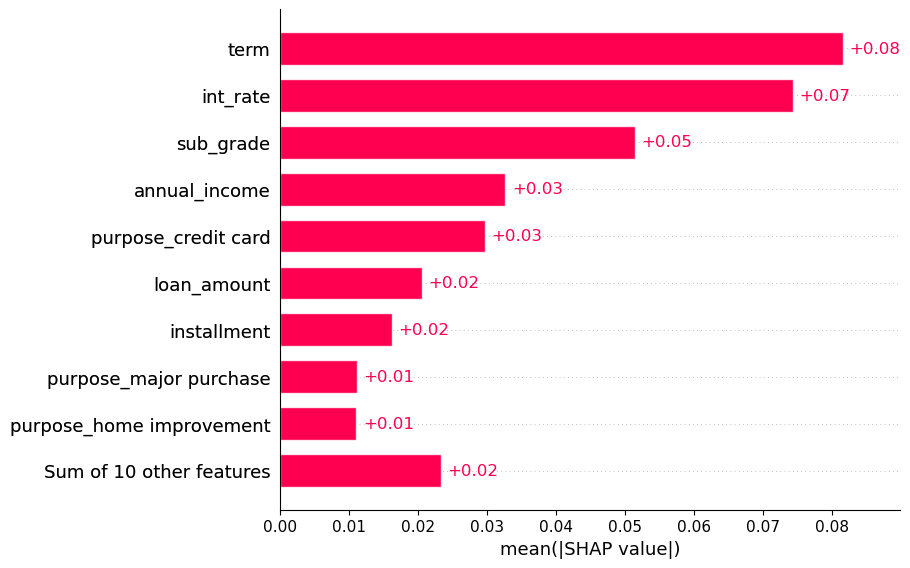

In [42]:
shap.plots.bar(shap_values)

### Beeswarm Plot

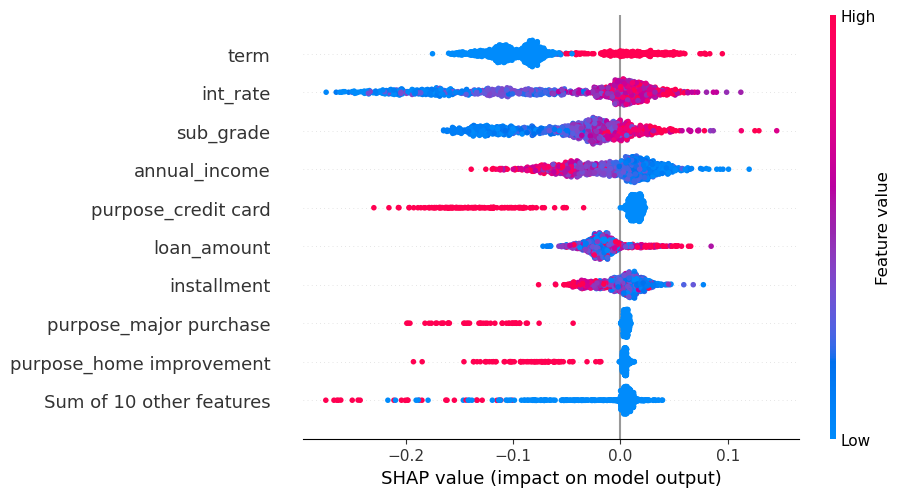

In [43]:
shap.plots.beeswarm(shap_values)

### Dependence Plots

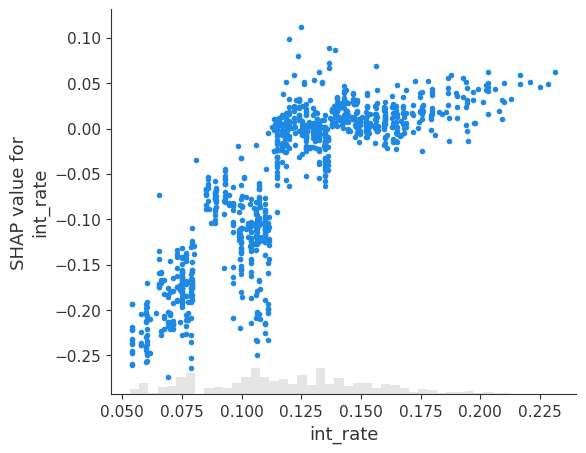

In [44]:
shap.plots.scatter(shap_values[:,'int_rate'])

# 2. Who to Be Accepted

Given the probability of **default**, we can make a decision who should be qualified to receive a loan. In the first approach, I use the probability of default and determine the qualified people.

If the goal is to provide interpretable results, we can use decision tree or other approaches that generate rules. However, if other metrics like accuracy or more importantly F1-score are of great importance, we can use **XGBoost**. In this section, I use **XGBoost**


## 2.1. Based on the Probability of Default

In [621]:
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes(include='bool').columns})


In [622]:
X_encoded

,int_rate,term,loan_amount,annual_income,installment,sub_grade,purpose_car,purpose_credit card,purpose_educational,purpose_home improvement,purpose_house,purpose_major purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small business,purpose_vacation,purpose_wedding
0,0.078800,36,4000,39000.000000,125.130000,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.209900,60,10000,100000.000000,270.480000,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.177400,36,14000,95000.000000,504.300000,24.0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.148300,36,4750,25000.000000,164.270000,17.0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.061700,36,2000,19200.000000,61.000000,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49845,0.170582,60,20982,55238.150846,522.144010,21.0,0,0,0,0,0,0,0,0,0,0,0,0,0
49846,0.147836,60,12548,59244.579987,297.259800,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0
49847,0.097868,44,15000,95391.964947,425.591536,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0
49848,0.110876,36,1061,35000.000000,34.780899,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [623]:
rf = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_encoded, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [624]:
ordinal_features = ['sub_grade']
nominal_features = ['purpose']
X_test = test_df[pd_selected_features]


X_test = encode_features(X_test, ordinal_features, nominal_features, pd_selected_features)
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include='bool').columns})
X_test['loan_status'] = test_df['loan_status']
X_test['profit'] = test_df['profit']

In [625]:
X_test['rf_prob'] = rf.predict_proba(X_test.drop(columns=['loan_status','profit']))[:,1]

### Determining the total profit based on the predicted probability of default

In [626]:
def total_profit(df, threshold=0.5):
    X = X_test.copy()
    X['default_pred'] = X['rf_prob']>threshold
    return X[X['default_pred']==0]['profit'].sum()
    

In [627]:
profit = list()
threshold_range = np.linspace(0,1,101)
maximum = 0 
for i in threshold_range:
    p = total_profit(X_test,i)
    if p>maximum:
        optimal_threshold = i
        maximum = p
    profit.append(p)

The best threshold is:  0.76
The total profit is:  9900704.59
Improvement is: $305,114.2800000012


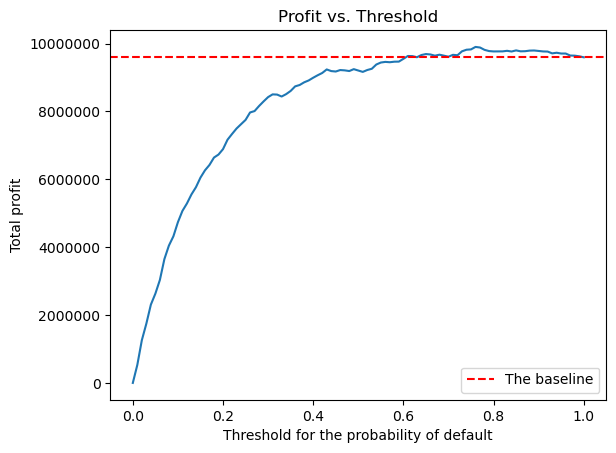

In [628]:
import matplotlib.pyplot as plt

print('The best threshold is: ', optimal_threshold)
print('The total profit is: ', maximum)
print(f"Improvement is: ${maximum - X_test['profit'].sum():,}")

# First plot: Total Profit
plt.figure()
plt.plot(threshold_range, profit)
plt.xlabel('Threshold for the probability of default')
plt.ylabel('Total profit')
plt.title('Profit vs. Threshold')
plt.ticklabel_format(style='plain', axis='y')
plt.axhline(y=X_test['profit'].sum(), color='red', linestyle='--', label='The baseline')

plt.legend()



### Optimizing the Parameters for Decision-Making

In the former model, we will not accept a loan request if $\mathbb{P}(default)\ge \theta$ where $\theta$ is a threshold which is optimized and it is equal to **0.76**.

Now, I consider a case where a loan request is rejected if $min(\gamma * \mathbb{P}(default),1) \ge \theta$ is satisfied. By tuning the value of $\gamma$ and $\theta$, it is possible to improve the performance of the model and the total improvement will be **$329,094**.

In [629]:
def total_profit2(df, mult, threshold):
    X = X_test.copy()
    X['default_pred'] = (mult * X['rf_prob']).clip(0, 1)>threshold
    return X[X['default_pred']==0]['profit'].sum()
    

In [630]:

threshold_range = np.linspace(0,1,101)
multiplier = np.arange(0.2, 1.5 + 0.01, 0.01)
maximum = 0 
for i in threshold_range:
    for mult in multiplier:
        p = total_profit2(X_test,i,mult)
        if p>maximum:
            optimal_threshold = i
            optimal_mult = mult
            maximum = p
        

In [631]:
print('maximum profit: ', maximum)
print(f"Improvement is: ${maximum - X_test['profit'].sum():,}")
print('The best multiplier: ', optimal_mult)
print('The best threshold: ', optimal_threshold)

maximum profit:  9924684.39
Improvement is: $329,094.08000000194
The best multiplier:  0.5100000000000002
The best threshold:  0.67


In [559]:
test_data_results ={'prob':X_test['rf_prob']}

## Improvement By Changing the Threshold for Accepting Loan Requests

In the test data set, all requests are accepted and based on that, the profit/loss is determined. However, it is possible to reject some loan request if those are risky. In the previous parts, we have used machine learning algorithm to predict the probability of default and determine which loan requests are risky. By tunnig the threshold for the probability of default, we can improve the total profit by **$329,094**

# 2.2 Profit/Loss Prediction

In this section, I am going to predict the profit for paid loans and the loss for defaulted loans.

Sine the ditributions of profit and loss are different, I train two different regression models. As profit and loss are right-skewed, I use **Gamma regression** for this purpose. 

In [560]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])

In [561]:
train_df.columns

Index(['id', 'address_state', 'application_type', 'emp_length', 'emp_title',
       'grade', 'home_ownership', 'issue_date', 'last_credit_pull_date',
       'last_payment_date', 'loan_status', 'next_payment_date', 'member_id',
       'purpose', 'sub_grade', 'term', 'verification_status', 'annual_income',
       'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc',
       'total_payment', 'fee_rate', 'profit'],
      dtype='object')

In [562]:
pro_irrelevant_features = ['id', 'member_id', 'emp_title', 'fee_rate']
pro_after_features = ['total_payment', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']
pro_leaky_features = ['issue_date', 'last_credit_pull_date', 'total_payment', 'profit']

pro_features_drop = pro_irrelevant_features + pro_after_features + pro_leaky_features

In [563]:
pro_features = train_df.drop(columns=pro_features_drop).columns.tolist()
pro_features

['address_state',
 'application_type',
 'emp_length',
 'grade',
 'home_ownership',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'verification_status',
 'annual_income',
 'dti',
 'installment',
 'int_rate',
 'loan_amount',
 'total_acc']

In [564]:
defaulted_train = train_df[pro_features+['profit']]
defaulted_train = defaulted_train[defaulted_train['loan_status']==1]
defaulted_train['term'] = defaulted_train['term'].astype('category')

defaulted_train

,address_state,application_type,emp_length,grade,home_ownership,loan_status,purpose,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,profit
22304,OH,INDIVIDUAL,8 years,F,RENT,1,Debt consolidation,F2,60,Verified,72000.0,0.2283,526.74,0.2062,25000,31,-12595.40
20615,NJ,INDIVIDUAL,1 year,C,RENT,1,Debt consolidation,C4,60,Source Verified,45000.0,0.1472,284.16,0.1479,12000,36,-8803.60
31050,FL,INDIVIDUAL,1 year,B,MORTGAGE,1,moving,B3,36,Not Verified,36500.0,0.1946,319.54,0.0933,10000,22,-8894.44
7106,WV,INDIVIDUAL,3 years,A,MORTGAGE,1,Debt consolidation,A3,36,Not Verified,43200.0,0.1889,512.39,0.0617,16800,51,-9648.04
31718,NJ,INDIVIDUAL,7 years,C,MORTGAGE,1,other,C5,36,Not Verified,92004.0,0.1603,260.84,0.1523,7500,21,-7389.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20505,AZ,INDIVIDUAL,3 years,E,MORTGAGE,1,Debt consolidation,E1,60,Source Verified,36000.0,0.1977,198.03,0.1799,7800,17,-11142.80
20491,KY,INDIVIDUAL,5 years,D,MORTGAGE,1,Debt consolidation,D4,60,Source Verified,54000.0,0.1298,371.91,0.1689,15000,14,-21575.60
7123,GA,INDIVIDUAL,2 years,B,MORTGAGE,1,Debt consolidation,B5,36,Not Verified,31000.0,0.1986,403.17,0.1136,12250,43,-8439.12
30419,PA,INDIVIDUAL,10+ years,C,MORTGAGE,1,medical,C2,36,Not Verified,80000.0,0.2001,102.93,0.1427,3000,22,-1347.48


## 2.1 Gamma Regression

In this section, I use **Gamma regression** to predict the total loss. As the results show, some features are insignificant. Therefore, we can remove them. 

### Loss Prediction

In [565]:
X = defaulted_train.drop(columns=['loan_status', 'profit'])
y = -defaulted_train['profit']


# Positivity of outcome varibale (-loss)
epsilon = 1e-5
y = y.clip(lower=epsilon)

# Log-transform numeric columns
num_cols = X.select_dtypes(include='number').columns
X[num_cols] = np.log1p(X[num_cols])

**Encoding**

In [567]:
ordinal_features = ['grade', 'sub_grade']
nominal_features = ['address_state', 'application_type', 'emp_length', 
                    'home_ownership', 'purpose', 'term', 'verification_status']

def fit_encoder(X, y, ordinal_features, nominal_features):
    grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrade_order = [f"{g}{n}" for g in grade_order for n in range(1, 6)]

    ordinal_encoder = OrdinalEncoder(categories=[grade_order, subgrade_order])
    mean_encoder = MeanEncoder(variables=nominal_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ('ord', ordinal_encoder, ordinal_features),
            ('mean', mean_encoder, nominal_features)
        ],
        remainder='passthrough'
    )

    passthrough = [col for col in X.columns if col not in (ordinal_features + nominal_features)]
    column_names = ordinal_features + nominal_features + passthrough

    X_transformed = preprocessor.fit_transform(X, y)
    X_encoded = pd.DataFrame(X_transformed, columns=column_names, index=X.index)

    return X_encoded, preprocessor, column_names

def transform_encoder(X, preprocessor, column_names):
    X_transformed = preprocessor.transform(X)
    return pd.DataFrame(X_transformed, columns=column_names, index=X.index)

In [568]:
passthrough = [col for col in X.columns if col not in (ordinal_features + nominal_features)]

X, preprocessor, column_names = fit_encoder(X, y, ordinal_features, nominal_features)

In [569]:
X = sm.add_constant(X, has_constant='add')

# Fit Gamma Regression using GLM
model = sm.GLM(y, X, family=Gamma(link=log_link()))
result = model.fit()

print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 profit   No. Observations:                 4252
Model:                            GLM   Df Residuals:                     4237
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                         0.20631
Method:                          IRLS   Log-Likelihood:                -40912.
Date:                Wed, 14 May 2025   Deviance:                       1422.5
Time:                        14:27:31   Pearson chi2:                     874.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.9485
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -1.41e-09   3

In [570]:
y_true = result.model.endog             # Actual target values (loss)
y_pred = result.predict()               # Predicted values from the GLM model

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 4789.18
MAE: 3342.48
R²: 0.6817


### Backward Step-Wise Model Selection

Since in the outcome of Gamma regression, there are multiple insignificant variables, I step **Backward Step-Wise Model Selection** to select a subset of variables.

In [571]:
def backward_selection(X, y, significance_level=0.05):

    # Initialize with all features
    remaining_features = list(X.columns)
    
    # Keep track of model performance
    current_aic = float("inf")
    best_model = None
    
    # Iteratively remove features
    while len(remaining_features) > 1:  # Keep at least the constant term
        worst_pvalue = 0
        worst_feature = None
        
        # Fit the model with current features
        model = sm.GLM(y, X[remaining_features], family=Gamma(link=log_link()))
        result = model.fit()
        
        # Update best model if AIC improves
        if result.aic < current_aic:
            current_aic = result.aic
            best_model = result
        
        # Find the least significant feature
        for feature in remaining_features:
            if feature == 'const':  # Skip the constant term
                continue
                
            p_value = result.pvalues[feature]
            if p_value > worst_pvalue:
                worst_pvalue = p_value
                worst_feature = feature
        
        # If the worst feature is not significant, remove it
        if worst_pvalue > significance_level and worst_feature is not None:
            remaining_features.remove(worst_feature)
            print(f"Removed: {worst_feature} (p-value: {worst_pvalue:.4f})")
        else:
            # No more features to remove
            print("No more features to remove. Backward selection complete.")
            break
    
    # Final model
    final_model = sm.GLM(y, X[remaining_features], family=Gamma(link=log_link()))
    final_result = final_model.fit()
    
    print("\nBackward Selection Results:")
    print(f"Selected features: {remaining_features}")
    print(f"Final model AIC: {final_result.aic:.4f}")
    
    return remaining_features, final_result


# Using Backward Selection
selected_features, best_model = backward_selection(X, y)
print(best_model.summary())



Removed: verification_status (p-value: 0.9730)
Removed: purpose (p-value: 0.7319)
Removed: grade (p-value: 0.6768)
Removed: application_type (p-value: 0.6883)
Removed: sub_grade (p-value: 0.6386)
Removed: dti (p-value: 0.5361)
Removed: home_ownership (p-value: 0.4177)
Removed: emp_length (p-value: 0.2850)
Removed: installment (p-value: 0.0504)
No more features to remove. Backward selection complete.

Backward Selection Results:
Selected features: ['const', 'address_state', 'term', 'annual_income', 'int_rate', 'loan_amount', 'total_acc']
Final model AIC: 81841.8900
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 profit   No. Observations:                 4252
Model:                            GLM   Df Residuals:                     4245
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                         0.20656
Method:                          I

In [572]:
X = X[['const', 'address_state', 'term', 'annual_income', 'int_rate', 'loan_amount', 'total_acc']]
y = -defaulted_train['profit']

loss_model = sm.GLM(y, X, family=Gamma(link=log_link()))
loss_result = loss_model.fit()
print(loss_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 profit   No. Observations:                 4252
Model:                            GLM   Df Residuals:                     4245
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                         0.20656
Method:                          IRLS   Log-Likelihood:                -40914.
Date:                Wed, 14 May 2025   Deviance:                       1423.9
Time:                        14:27:32   Pearson chi2:                     877.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9482
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6210      0.164     -3.781

In [573]:
X

,const,address_state,term,annual_income,int_rate,loan_amount,total_acc
22304,1.0,10346.473982,13480.163400,11.184435,0.187475,10.126671,3.465736
20615,1.0,9448.109296,13480.163400,10.714440,0.137934,9.392745,3.610918
31050,1.0,9400.392581,6081.862886,10.505095,0.089201,9.210440,3.135494
7106,1.0,9481.207059,6081.862886,10.673619,0.059871,9.729194,3.951244
31718,1.0,9448.109296,6081.862886,11.429598,0.141760,8.922792,3.091042
...,...,...,...,...,...,...,...
20505,1.0,8837.800976,13480.163400,10.491302,0.165430,8.962007,2.890372
20491,1.0,12202.407368,13480.163400,10.896758,0.156063,9.615872,2.708050
7123,1.0,8552.116585,6081.862886,10.341775,0.107598,9.413363,3.784190
30419,1.0,9259.438529,6081.862886,11.289794,0.133394,8.006701,3.135494


### Loss Prediction on the Test Data

Now, given the model for loss prediction, we predict the amount of loss for the test data if the loan is ``defaulted``.

In [574]:
X_test = test_df.drop(columns=['loan_status', 'profit'])
X_test['term'] = X_test['term'].astype('category')

# Log-transform numeric columns
num_cols = X_test.select_dtypes(include='number').columns
X_test[num_cols] = np.log1p(X_test[num_cols])

test_index = X_test.index

X_test = preprocessor.transform(X_test)

column_names = ordinal_features + nominal_features + passthrough

# Create DataFrame with proper names
X_test = pd.DataFrame(X_test, columns=column_names, index=test_index)

In [575]:
X_test = X_test[['address_state', 'term', 'annual_income', 'int_rate', 'loan_amount', 'total_acc']]
X_test = sm.add_constant(X_test, has_constant='add')

predicted_loss = loss_result.predict(X_test)

predicted_profit = -predicted_loss
predicted_profit

16       -1855.513110
7616     -4191.232205
1807     -4887.692900
32977    -3895.114236
4588     -3599.729797
             ...     
15614    -7635.592967
2565    -10515.427385
34428    -2771.237700
30511    -4353.308558
5573     -8337.865702
Length: 7295, dtype: float64

In [576]:
test_df['expected_loss'] = predicted_profit
test_data_results['expected_loss'] = predicted_profit

## Profit Prediction

In [577]:
paid_train = train_df[pro_features+['profit']]
paid_train = paid_train[paid_train['loan_status']==0]
paid_train['term'] = paid_train['term'].astype('category')



In [578]:
X = paid_train.drop(columns=['loan_status', 'profit'])
y = paid_train['profit']

# Ensure y is strictly positive
epsilon = 1e-5
y = y.clip(lower=epsilon)

# Log-transform numeric columns
num_cols = X.select_dtypes(include='number').columns
X[num_cols] = np.log1p(X[num_cols])

# Encode categorical variables
X, encoder_profit, columns_namess = fit_encoder(X, y, ordinal_features, nominal_features) 

# Add constant for intercept
X = sm.add_constant(X, has_constant='add')

# Fit Gamma Regression using GLM
profit_model = sm.GLM(y, X, family=Gamma(link=log_link()))
profit_result = profit_model.fit()

print(profit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 profit   No. Observations:                24925
Model:                            GLM   Df Residuals:                    24910
Model Family:                   Gamma   Df Model:                           14
Link Function:                    log   Scale:                       0.0089796
Method:                          IRLS   Log-Likelihood:            -1.6825e+05
Date:                Wed, 14 May 2025   Deviance:                       271.41
Time:                        14:27:33   Pearson chi2:                     224.
No. Iterations:                    23   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.438e-06   6

## Profit/Loss Prediction

In [579]:
test_df = test_df[pro_features+['profit']]

In [580]:
test_df

,address_state,application_type,emp_length,grade,home_ownership,loan_status,purpose,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,profit
16,TX,INDIVIDUAL,1 year,B,RENT,0,car,B1,36,Verified,16800.0,0.0350,98.29,0.0991,3050,8,549.44
7616,NJ,INDIVIDUAL,3 years,E,RENT,1,Debt consolidation,E2,36,Not Verified,47500.0,0.0076,213.01,0.1670,6000,5,-2743.36
1807,CA,INDIVIDUAL,10+ years,D,MORTGAGE,1,credit card,D4,36,Not Verified,55000.0,0.2151,254.70,0.1355,7500,19,-1706.20
32977,CT,INDIVIDUAL,4 years,B,RENT,0,other,B4,36,Not Verified,84000.0,0.1810,215.57,0.1189,6500,30,1390.52
4588,PA,INDIVIDUAL,1 year,B,RENT,1,credit card,B2,36,Verified,56000.0,0.1116,197.82,0.1148,6000,14,-4176.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15614,CA,INDIVIDUAL,1 year,D,RENT,0,Debt consolidation,D2,36,Source Verified,120000.0,0.1193,415.46,0.1491,12000,13,3556.56
2565,CA,INDIVIDUAL,7 years,D,MORTGAGE,0,credit card,D3,36,Not Verified,91980.0,0.1435,531.00,0.1649,15000,29,4866.00
34428,SD,INDIVIDUAL,3 years,B,RENT,0,other,B2,36,Verified,39000.0,0.1714,161.93,0.1025,5000,16,929.48
30511,FL,INDIVIDUAL,10+ years,A,OWN,0,medical,A4,36,Not Verified,50000.0,0.1798,248.82,0.0749,8000,25,1117.52


### Profit prediction

In [581]:
X_test = test_df.drop(columns=['loan_status', 'profit'])
X_test['term'] = X_test['term'].astype('category')

num_cols = X_test.select_dtypes(include='number').columns
X_test[num_cols] = np.log1p(X_test[num_cols])

test_index = X_test.index

X_test = encoder_profit.transform(X_test)

column_names = ordinal_features + nominal_features + passthrough


X_test = pd.DataFrame(X_test, columns=column_names, index=test_index)
X_test = sm.add_constant(X_test, has_constant='add')

In [582]:
predicted_profit = profit_result.predict(X_test)

In [583]:
test_df['expected_profit'] = predicted_profit
test_data_results['expected_profit'] = predicted_profit

In [584]:
test_df['prob'] = test_data_results['prob']
test_df['expected_loss'] = test_data_results['expected_loss']

In [585]:
test_df

,address_state,application_type,emp_length,grade,home_ownership,loan_status,purpose,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,profit,expected_profit,prob,expected_loss
16,TX,INDIVIDUAL,1 year,B,RENT,0,car,B1,36,Verified,16800.0,0.0350,98.29,0.0991,3050,8,549.44,564.757633,0.126683,-1855.513110
7616,NJ,INDIVIDUAL,3 years,E,RENT,1,Debt consolidation,E2,36,Not Verified,47500.0,0.0076,213.01,0.1670,6000,5,-2743.36,1920.168306,0.176881,-4191.232205
1807,CA,INDIVIDUAL,10+ years,D,MORTGAGE,1,credit card,D4,36,Not Verified,55000.0,0.2151,254.70,0.1355,7500,19,-1706.20,1765.372903,0.248139,-4887.692900
32977,CT,INDIVIDUAL,4 years,B,RENT,0,other,B4,36,Not Verified,84000.0,0.1810,215.57,0.1189,6500,30,1390.52,1426.560669,0.101557,-3895.114236
4588,PA,INDIVIDUAL,1 year,B,RENT,1,credit card,B2,36,Verified,56000.0,0.1116,197.82,0.1148,6000,14,-4176.52,1284.371019,0.048425,-3599.729797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15614,CA,INDIVIDUAL,1 year,D,RENT,0,Debt consolidation,D2,36,Source Verified,120000.0,0.1193,415.46,0.1491,12000,13,3556.56,3358.296213,0.195347,-7635.592967
2565,CA,INDIVIDUAL,7 years,D,MORTGAGE,0,credit card,D3,36,Not Verified,91980.0,0.1435,531.00,0.1649,15000,29,4866.00,4881.776407,0.085344,-10515.427385
34428,SD,INDIVIDUAL,3 years,B,RENT,0,other,B2,36,Verified,39000.0,0.1714,161.93,0.1025,5000,16,929.48,939.658948,0.180574,-2771.237700
30511,FL,INDIVIDUAL,10+ years,A,OWN,0,medical,A4,36,Not Verified,50000.0,0.1798,248.82,0.0749,8000,25,1117.52,1148.763833,0.014223,-4353.308558


In [586]:
test_data_results

{'prob': 16       0.126683
 7616     0.176881
 1807     0.248139
 32977    0.101557
 4588     0.048425
            ...   
 15614    0.195347
 2565     0.085344
 34428    0.180574
 30511    0.014223
 5573     0.201472
 Name: rf_prob, Length: 7295, dtype: float32,
 'expected_loss': 16       -1855.513110
 7616     -4191.232205
 1807     -4887.692900
 32977    -3895.114236
 4588     -3599.729797
              ...     
 15614    -7635.592967
 2565    -10515.427385
 34428    -2771.237700
 30511    -4353.308558
 5573     -8337.865702
 Length: 7295, dtype: float64,
 'expected_profit': 16        564.757633
 7616     1920.168306
 1807     1765.372903
 32977    1426.560669
 4588     1284.371019
             ...     
 15614    3358.296213
 2565     4881.776407
 34428     939.658948
 30511    1148.763833
 5573     4598.241394
 Length: 7295, dtype: float64}

## 2.3 Decision-Making based on the Profit and the Loss

### Approach 1

Suppose that a loan is defaulted by probability $p$ and the loss $l$, and it will be paid by probability of $1-p$ with the profit $\pi$. In this case, the expected total profit will be $\pi (1-p) + p l$. We should accept a loan if this expected profit is positive, or equivalently, $p\le \frac{\pi}{\pi + l}$.

Since out predicitions have some errors, instead of the threshold $\frac{\pi}{\pi + l}$, I use $\frac{\gamma \pi}{\pi + l}$ where $\gamma$ is a tunable parameter and its best value is $\gamma=2.13$.

By using this approach, the total improvement will be **$718,323**.

In [587]:
def decision_making(df, threshold=0.5):
    X = df.copy()
    X['default_pred'] = X['prob'] > threshold*( X['expected_profit']/(  X['expected_profit'] + np.abs(X['expected_loss']) ) )
    return X[X['default_pred']==0]['profit'].sum()
    

In [588]:
profit = list()
threshold_range = np.arange(0.2, 4 + 0.01, 0.01)
maximum = 0 
for i in threshold_range:
    p = decision_making(test_df,i)
    if p>maximum:
        optimal_threshold = i
        maximum = p
    profit.append(p)

The best threshold is:  2.1300000000000017
The total profit is:  10313913.58
Improvement is: $718,323.2700000014


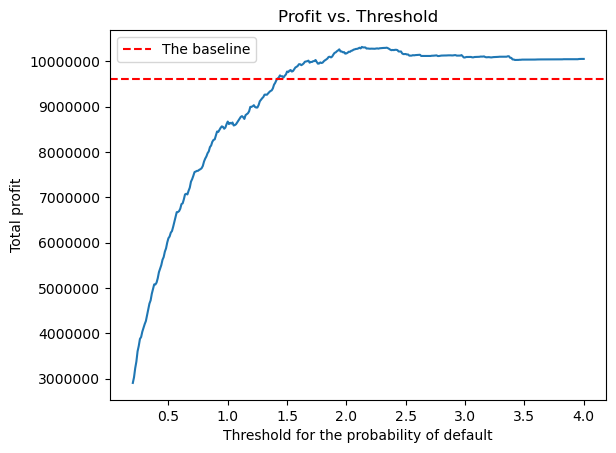

In [589]:
import matplotlib.pyplot as plt

print('The best threshold is: ', optimal_threshold)
print('The total profit is: ', maximum)
print(f"Improvement is: ${maximum - test_df['profit'].sum():,}")

# First plot: Total Profit
plt.figure()
plt.plot(threshold_range, profit)
plt.xlabel('Threshold for the probability of default')
plt.ylabel('Total profit')
plt.title('Profit vs. Threshold')
plt.ticklabel_format(style='plain', axis='y')
plt.axhline(y=test_df['profit'].sum(), color='red', linestyle='--', label='The baseline')

plt.legend()



### Approach 2

In this approach, instead of the threshold $\frac{\gamma \pi}{\pi + l}$, I use a more general threshold in form of $\frac{\gamma \pi}{\pi + \beta l}$ and the best values for $\gamma$ and $\beta$ are as follows:

$$\gamma=1.7$$

$$\beta=0.69$$

$$\text{Total Improvement} = $731,441$$

In [590]:
def decision_making2(df, threshold=0.5, beta=0.5):
    X = df.copy()
    X['default_pred'] = X['prob'] > threshold*( X['expected_profit']/(  X['expected_profit'] + beta*np.abs(X['expected_loss']) ) )
    return X[X['default_pred']==0]['profit'].sum()
    

In [591]:
threshold_range = np.arange(0.2, 4 + 0.01, 0.01)
BETA = np.arange(0.2, 1.5 + 0.01, 0.01)
maximum = 0 
for i in threshold_range:
    for beta in BETA:
        p = decision_making2(test_df,i,beta)
        if p>maximum:
            optimal_threshold = i
            optimal_beta = beta
            maximum = p
        

In [592]:
print('maximum profit: ', maximum)
print(f"Improvement is: ${maximum - test_df['profit'].sum():,}")
print('The best beta: ', optimal_beta)
print('The best threshold: ', optimal_threshold)

maximum profit:  10327031.32
Improvement is: $731,441.0100000016
The best beta:  0.6900000000000004
The best threshold:  1.7000000000000013
